In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
import calendar

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [2]:
#load fraudulent profile 1375
badguy = pd.read_excel('/Users/marcjene/fraud_detection/sonya_mt/1757_new.xlsx')
badguy['Timestamp'] = pd.to_datetime(badguy['Timestamp'])
badguy = badguy.rename(columns={"kWh": "power"})
badguy.head()

,Timestamp,power
0,2009-07-27 00:00:00,0.072
1,2009-07-27 00:30:00,0.171
2,2009-07-27 01:00:00,0.093
3,2009-07-27 01:30:00,0.055
4,2009-07-27 02:00:00,0.055


In [3]:
badguy.dtypes

Timestamp    datetime64[ns]
power               float64
dtype: object

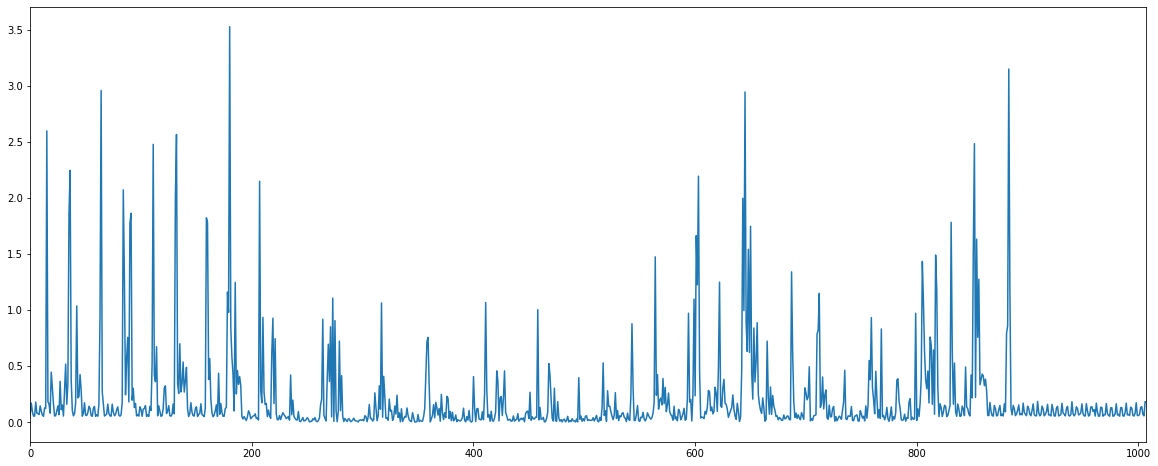

In [4]:
badguy['power'][0:1008].plot(figsize = (20,8))
plt.show()

In [5]:
df_bg=badguy.copy()

df_bg['date'] = df_bg['Timestamp'].apply(lambda x:x.strftime('%Y%m%d'))

df_bg['time'] = df_bg['Timestamp'].apply(lambda x:x.strftime('%H:%M'))

df_bg = df_bg.drop(['Timestamp'], axis=1)
df_bg.head()

,power,date,time
0,0.072,20090727,00:00
1,0.171,20090727,00:30
2,0.093,20090727,01:00
3,0.055,20090727,01:30
4,0.055,20090727,02:00


# Approach 1a (Normalized)
### K-Means + Artificial Features

In [6]:
list_days=df_bg['date'].unique()
list_days

array(['20090727', '20090728', '20090729', '20090730', '20090731',
       '20090801', '20090802', '20090803', '20090804', '20090805',
       '20090806', '20090807', '20090808', '20090809', '20090810',
       '20090811', '20090812', '20090813', '20090814', '20090815',
       '20090816'], dtype=object)

In [7]:
#How many different days are there?
n=df_bg['date'].nunique()
n

21

<Figure size 432x288 with 0 Axes>

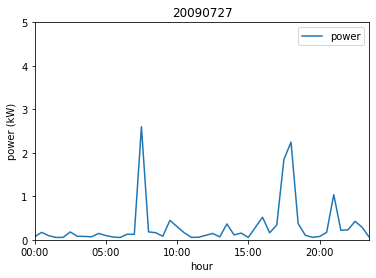

<Figure size 432x288 with 0 Axes>

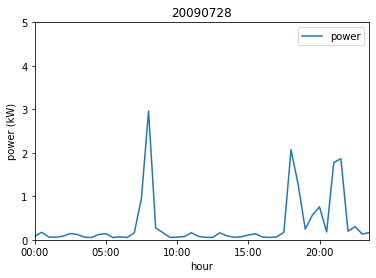

<Figure size 432x288 with 0 Axes>

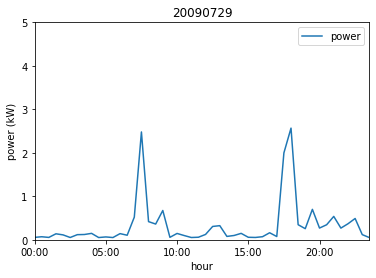

<Figure size 432x288 with 0 Axes>

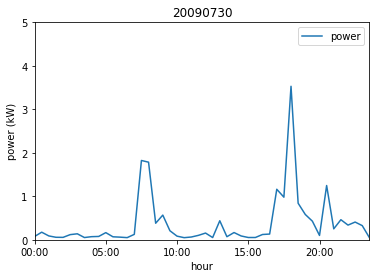

<Figure size 432x288 with 0 Axes>

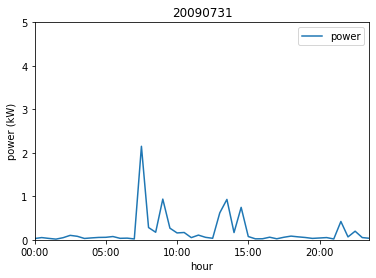

<Figure size 432x288 with 0 Axes>

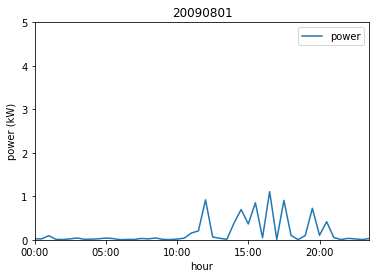

<Figure size 432x288 with 0 Axes>

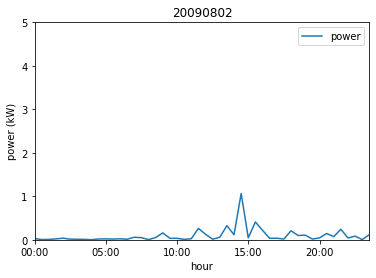

<Figure size 432x288 with 0 Axes>

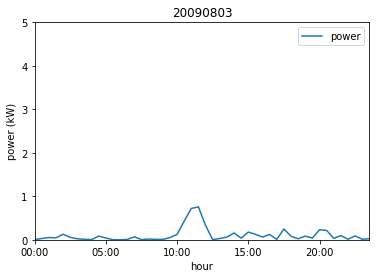

<Figure size 432x288 with 0 Axes>

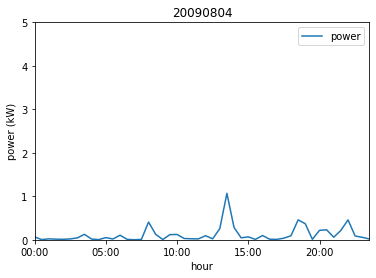

<Figure size 432x288 with 0 Axes>

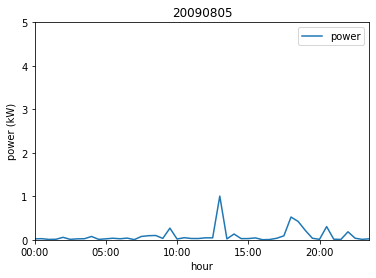

In [8]:
for day in list_days[0:10]:
    df = df_bg.loc[df_bg['date']==day]
    df = df.set_index('time')
    df
    new_df=df.drop(['date'], axis=1)
    new_df
    plt.figure()
    new_df.plot()
    plt.legend(loc='best')
    plt.title(day)
    plt.xlabel('hour')
    plt.ylim(0,5)
    plt.ylabel('power (kW)')

In [9]:
daily_meter = pd.DataFrame()
for day in list_days:
    E_ref = df_bg.loc[df_bg['date']==day,('time','date','power')]
    
    if E_ref['power'].max()==0:
        E_ref['norm_power']=0
    else:
        E_ref['norm_power'] = E_ref['power']/E_ref['power'].max()
        
    E_ref['date']=day
    E_ref.reset_index(inplace=True)
    daily_meter=daily_meter.append(E_ref,ignore_index=True)
    
daily_meter=daily_meter.set_index('index')
daily_meter.head()

,time,date,power,norm_power
index,,,,
0,00:00,20090727,0.072,0.027692
1,00:30,20090727,0.171,0.065769
2,01:00,20090727,0.093,0.035769
3,01:30,20090727,0.055,0.021154
4,02:00,20090727,0.055,0.021154


<Figure size 432x288 with 0 Axes>

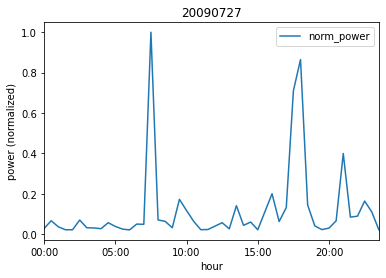

<Figure size 432x288 with 0 Axes>

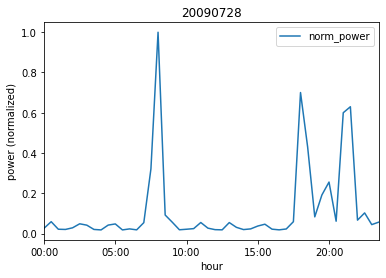

<Figure size 432x288 with 0 Axes>

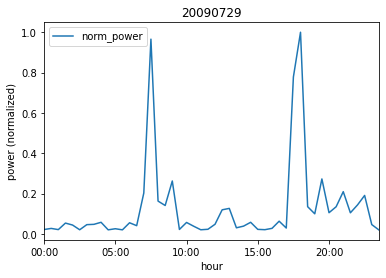

<Figure size 432x288 with 0 Axes>

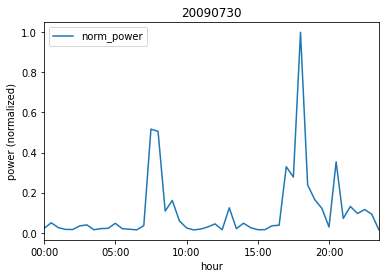

<Figure size 432x288 with 0 Axes>

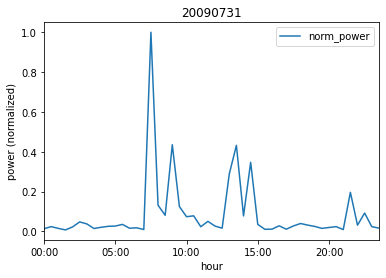

<Figure size 432x288 with 0 Axes>

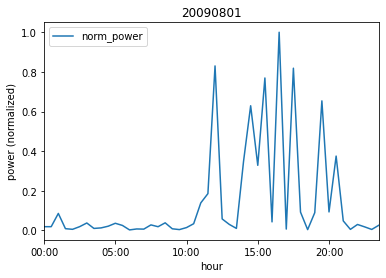

<Figure size 432x288 with 0 Axes>

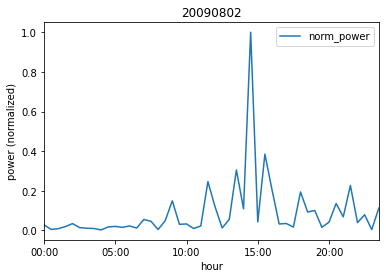

<Figure size 432x288 with 0 Axes>

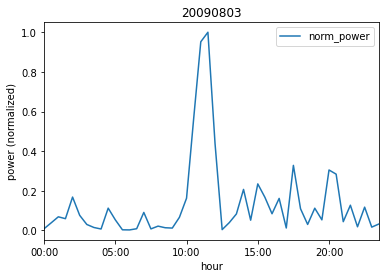

<Figure size 432x288 with 0 Axes>

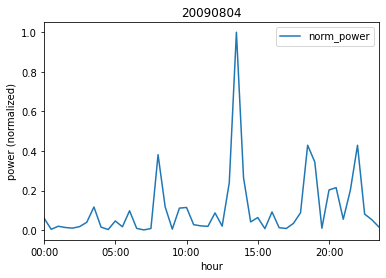

<Figure size 432x288 with 0 Axes>

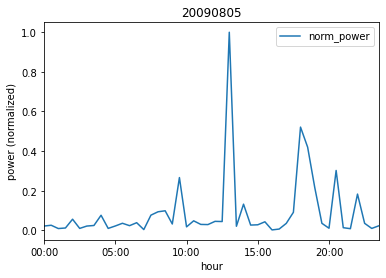

In [10]:
for day in list_days[0:10]:
    df = daily_meter.loc[df_bg['date']==day]
    df = df.set_index('time')
    df
    new_df=df.drop(['date','power'], axis=1)
    new_df
    plt.figure()
    new_df.plot()
    plt.legend(loc='best')
    plt.title(day)
    plt.xlabel('hour')
    plt.ylabel('power (normalized)')

In [11]:
df_cluster=daily_meter.copy()

In [12]:
#Example of how to count cuts
df = df_cluster[df_cluster['date']=='20090727']
mean = df['norm_power'].mean()
power = df.iloc[0]['norm_power']
above_0 = (power>mean)
prev_above = above_0
cuts = 0
i=0
for index, row in df.iterrows():
    if i!=0:
        power = row['norm_power']
        above = power>mean
        if above!=prev_above:
            cuts += 1
            above = (power>mean)
        prev_above=above
        i+=1
        #print(i, cuts)
    else:
        i+=1
        #print(i, cuts)
        
if above_0!=above:
    cuts += 1
    
print (cuts)

14


In [13]:
#CUTS FUNCTION
def cuts(df,mean):
    power = df.iloc[0]['norm_power']
    above_0 = (power>mean)
    prev_above = above_0
    cuts = 0
    i=0
    for index, row in df.iterrows():
        if i!=0:
            power = row['norm_power']
            above = power>mean
            if above!=prev_above:
                cuts += 1
                above = (power>mean)
            prev_above=above
            i+=1
        else:
            i+=1
    if above_0!=above:
        cuts += 1    
    return (cuts)

In [14]:
#Example of how to count slopes
df = df_cluster[df_cluster['date']=='20090727']
mean = df['norm_power'].mean()
power = df.iloc[0]['norm_power']
previous_p = power
inc = 0
dec = 0
power_0 = power
for index, row in df.iterrows():
    #print(power, inc, dec)
    power = row['norm_power']
    if power>(previous_p+0.5*mean):
        inc += 1
    elif power<(previous_p-0.5*mean):
        dec += 1
    previous_p = power
if power_0>(previous_p+0.5*mean):
    inc += 1
elif power_0>(previous_p-0.5*mean):
    dec += 1
print (inc,dec)

10 8


In [15]:
#SLOPES FUNCTION
def deep_slopes(df, mean):
    power = df.iloc[0]['norm_power']
    previous_p = power
    inc = 0
    dec = 0
    power_0 = power
    for index, row in df.iterrows():
        #print(power, inc, dec)
        power = row['norm_power']
        if power>(previous_p+0.5*mean):
            inc += 1
        elif power<(previous_p-0.5*mean):
            dec += 1
        previous_p = power
    if power_0>(previous_p+0.5*mean):
        inc += 1
    elif power_0>(previous_p-0.5*mean):
        dec += 1
    return (inc,dec)

In [16]:
#FEATURES SELECTION
df = pd.DataFrame(columns=['date','norm_mean','norm_median','norm_std','norm_mean_p1','norm_mean_p2','norm_mean_p3',
                           'n_cuts','inc','dec'])
meter_stat = pd.DataFrame(columns=['norm_mean','norm_median','norm_std','norm_mean_p1','norm_mean_p2','norm_mean_p3',
                                   'n_cuts','inc','dec'])

df_cluster['datetime'] =  pd.to_datetime(df_cluster['time'], format='%H:%M')

for day in list_days:
    daily_ref = df_cluster[df_cluster['date'] == day]
    
    mean = daily_ref['norm_power'].mean()
    
    std = daily_ref['norm_power'].std()
    
    median = daily_ref['norm_power'].median()
    
    daily_p1 = daily_ref[daily_ref['datetime'].dt.hour < 8]
    mean_p1 = daily_p1['norm_power'].mean()
    
    daily_p2 = daily_ref[(daily_ref['datetime'].dt.hour > 8) & (daily_ref['datetime'].dt.hour < 16)]
    mean_p2 = daily_p2['norm_power'].mean()
    
    daily_p3 = daily_ref[(daily_ref['datetime'].dt.hour > 16) & (daily_ref['datetime'].dt.hour < 24)]
    mean_p3 = daily_p3['norm_power'].mean()
    
    n_cuts = cuts(daily_ref,mean)
    
    inc, dec = deep_slopes(daily_ref,mean)
    
    df = df.append({'date':day,'norm_mean':mean,'norm_std':std, 'norm_median':median, 'norm_mean_p1':mean_p1,
                    'norm_mean_p2':mean_p2, 'norm_mean_p3':mean_p3, 'n_cuts':n_cuts, 'inc':inc, 'dec':dec},
                   ignore_index=True)
    
df_features=df
df_features.head()

,date,norm_mean,norm_median,norm_std,norm_mean_p1,norm_mean_p2,norm_mean_p3,n_cuts,inc,dec
0,20090727,0.119856,0.056154,0.205786,0.097788,0.065852,0.205165,14,10,8
1,20090728,0.118569,0.043060,0.208467,0.050426,0.032156,0.235900,8,6,6
2,20090729,0.129632,0.050818,0.216637,0.104434,0.063390,0.233534,10,8,8
3,20090730,0.109106,0.036402,0.178272,0.056763,0.043545,0.216694,14,6,9
4,20090731,0.086633,0.026500,0.169171,0.083179,0.144081,0.039973,12,7,10


In [17]:
df_features = df_features.set_index('date')

In [18]:
df_features.isnull().any().any()

False

In [19]:
# Importing StandardScaler method for SkLearn 
from sklearn.preprocessing import StandardScaler

# Creating the instance for Standard Scaler 
scaler = StandardScaler()

# Fitting the scaler with meter_stat
scaler.fit(df_features)

# Transforming the meter_stat df into an scaled one. 
df_features_scaled = pd.DataFrame(scaler.transform(df_features), index=df_features.index, columns=df_features.columns)

In [20]:
df_features_scaled.head(10)

,norm_mean,norm_median,norm_std,norm_mean_p1,norm_mean_p2,norm_mean_p3,n_cuts,inc,dec
date,,,,,,,,,
20090727,-0.332403,-0.234113,0.247527,-0.083609,-0.723201,-0.061923,0.361620,0.342682,-0.800261
20090728,-0.343247,-0.361783,0.345634,-0.431689,-0.967451,0.164654,-0.978502,-1.456400,-1.547171
20090729,-0.250005,-0.286141,0.644623,-0.034766,-0.741044,0.147209,-0.531795,-0.556859,-0.800261
20090730,-0.422999,-0.426696,-0.759410,-0.385116,-0.884895,0.023067,0.361620,-1.456400,-0.426806
20090731,-0.612409,-0.523249,-1.092470,-0.190981,-0.156139,-1.279705,-0.085087,-1.006629,-0.053351
20090801,-0.094945,-0.497723,2.263860,-0.643055,0.554786,-0.380142,-0.085087,0.342682,-0.053351
20090802,-0.588626,-0.444016,-1.475119,-0.654946,0.104134,-0.962001,0.808328,-0.107088,0.693559
20090803,-0.182471,-0.169542,0.492404,-0.457263,0.861625,-0.736196,0.361620,2.141765,1.067014
20090804,-0.411583,-0.347282,-0.912673,-0.577433,-0.148438,-0.428878,0.361620,1.242224,2.187380


In [21]:
#Drop not a number values
df_features_scaled=df_features_scaled.dropna()
df_features=df_features.dropna()
nan_rows = df_features_scaled[df_features_scaled.isnull().any(1)]
nan_rows

,norm_mean,norm_median,norm_std,norm_mean_p1,norm_mean_p2,norm_mean_p3,n_cuts,inc,dec
date,,,,,,,,,


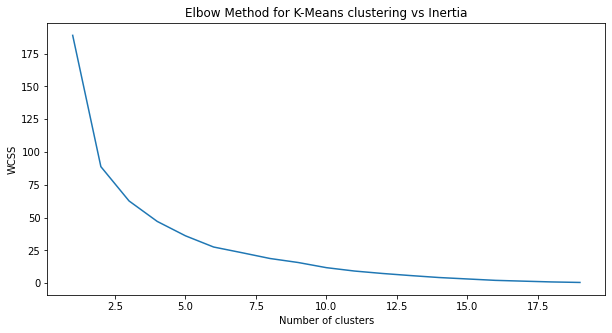

In [22]:
# Importing the library for KMeans 
from sklearn.cluster import KMeans

# Creating an empty list 
wcss = []

#ELBOW METHOD
# Creating a for loop for clusters between 1 and 12. 
# We create an instance, we fit the model and calculate the inertia 
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(df_features_scaled)
    wcss.append (kmeans.inertia_)
# Plotting the inertia in front of each iteration 
plt.figure(figsize=(10,5))
plt.plot(range(1, 20), wcss)

# Setting aesthetics of the plot. 
plt.title('Elbow Method for K-Means clustering vs Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

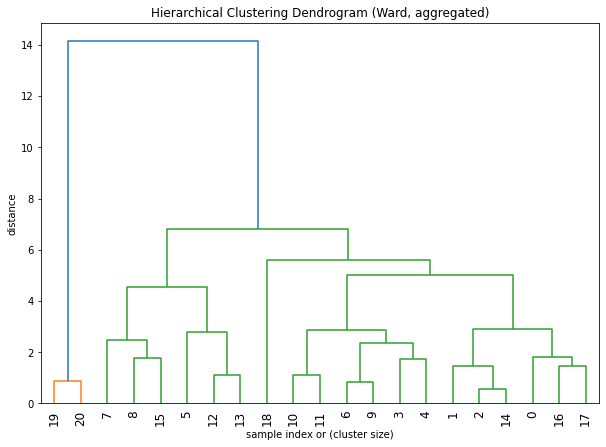

In [23]:
#DENDOGRAM METHOD

# Hierarchical algorithm for clustering. Import hierarchical algorithm method. 
from scipy.cluster.hierarchy import dendrogram, linkage

# Creating a new hierarchical algorithm  
linkage_matrix = linkage(df_features_scaled, 'ward')

# Creating the figure 
figure = plt.figure(figsize=(10, 7))

# The hierarchical algorithm will be reduced, only showing the converged clusters.
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=24,                   # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,   # to get a distribution impression in truncated branches
)

# Setting aesthetics of the plot 
plt.title('Hierarchical Clustering Dendrogram (Ward, aggregated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.show()

In [24]:
#CLUSTERING
# We assume 2 clusters 
kmeans = KMeans(n_clusters=2)

# Fitting the input data
kmeans.fit(df_features_scaled)

# Including the labels in the database 
df_features['labels'] = kmeans.labels_

In [25]:
# Counting the number of clients under each label. 
df_features['labels'].value_counts()

0    19
1     2
Name: labels, dtype: int64

In [26]:
print(f"The inertia of the model with k=2 is {kmeans.inertia_}")

The inertia of the model with k=2 is 88.84286051318247


In [27]:
df_features[df_features.index=='20090727']

,norm_mean,norm_median,norm_std,norm_mean_p1,norm_mean_p2,norm_mean_p3,n_cuts,inc,dec,labels
date,,,,,,,,,,
20090727,0.119856,0.056154,0.205786,0.097788,0.065852,0.205165,14,10,8,0


In [28]:
df_features[df_features.index=='20090801']

,norm_mean,norm_median,norm_std,norm_mean_p1,norm_mean_p2,norm_mean_p3,n_cuts,inc,dec,labels
date,,,,,,,,,,
20090801,0.14803,0.029118,0.260883,0.021667,0.242157,0.161998,12,10,10,0


In [29]:
v_label=[]
for ind in daily_meter.index:
    date = daily_meter['date'][ind]
    if date in df_features.index:
        v_label=v_label+[df_features['labels'][date]]
    else:
        v_label=v_label+['NaN']
daily_meter['label']=v_label
daily_meter.head()

,time,date,power,norm_power,label
index,,,,,
0,00:00,20090727,0.072,0.027692,0
1,00:30,20090727,0.171,0.065769,0
2,01:00,20090727,0.093,0.035769,0
3,01:30,20090727,0.055,0.021154,0
4,02:00,20090727,0.055,0.021154,0


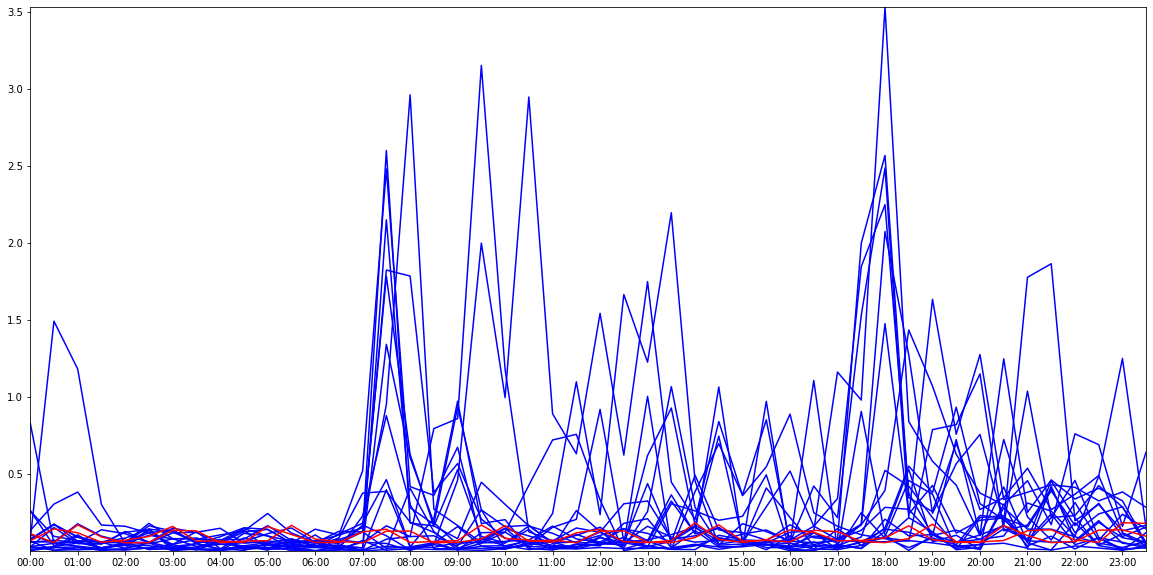

In [30]:
list_labels = daily_meter['label'].unique()
plt.figure(figsize=(20,10))

for label in list_labels:
    df_label = daily_meter.loc[daily_meter['label']==label]
    list_dates = df_label['date'].unique()
    for date in list_dates:
        df_label_date = df_label.loc[df_label['date']==date]
        if label==0:
            plt.plot(df_label_date['time'],df_label_date['power'],'b')
        else:
            plt.plot(df_label_date['time'],df_label_date['power'],'r')

plt.xticks(np.arange(0, 48, step=2))
plt.margins(x=0, y=0)
plt.show()        

# Approach 1b (Not Normalized)
### K-Means + Artificial Features

In [31]:
df_bg_1b = df_bg.copy()

In [32]:
list_days=df_bg_1b['date'].unique()
list_days

array(['20090727', '20090728', '20090729', '20090730', '20090731',
       '20090801', '20090802', '20090803', '20090804', '20090805',
       '20090806', '20090807', '20090808', '20090809', '20090810',
       '20090811', '20090812', '20090813', '20090814', '20090815',
       '20090816'], dtype=object)

In [33]:
#How many different days are there?
n=df_bg_1b['date'].nunique()
n

21

<Figure size 432x288 with 0 Axes>

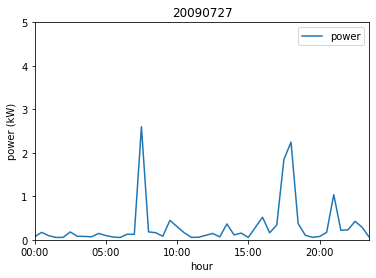

<Figure size 432x288 with 0 Axes>

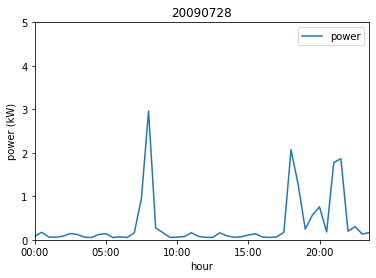

<Figure size 432x288 with 0 Axes>

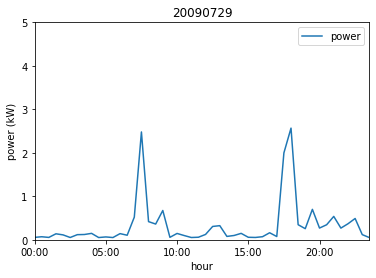

<Figure size 432x288 with 0 Axes>

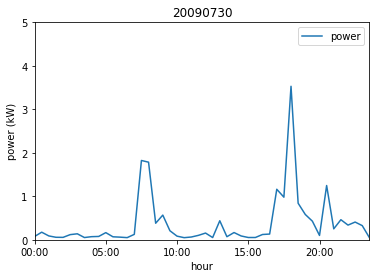

<Figure size 432x288 with 0 Axes>

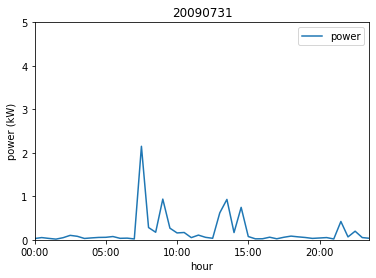

<Figure size 432x288 with 0 Axes>

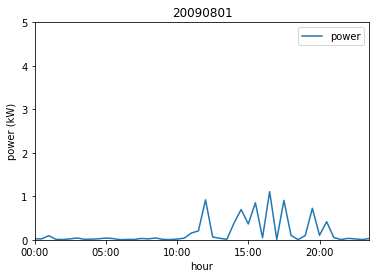

<Figure size 432x288 with 0 Axes>

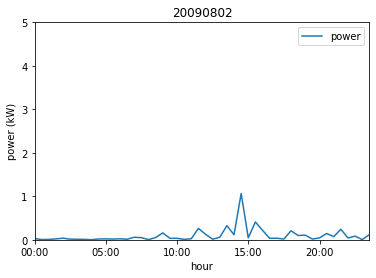

<Figure size 432x288 with 0 Axes>

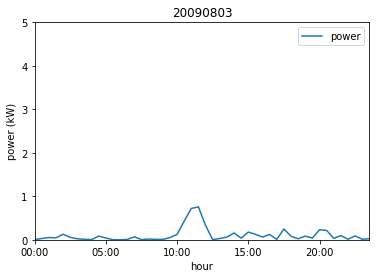

<Figure size 432x288 with 0 Axes>

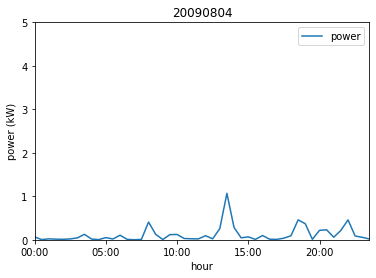

<Figure size 432x288 with 0 Axes>

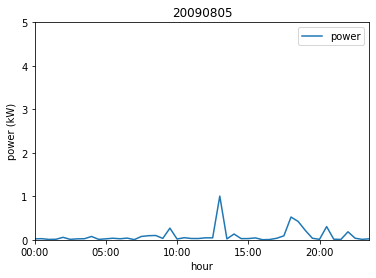

In [34]:
for day in list_days[0:10]:
    df = df_bg_1b.loc[df_bg['date']==day]
    df = df.set_index('time')
    df
    new_df=df.drop(['date'], axis=1)
    new_df
    plt.figure()
    new_df.plot()
    plt.legend(loc='best')
    plt.title(day)
    plt.xlabel('hour')
    plt.ylim(0,5)
    plt.ylabel('power (kW)')

In [35]:
df_cluster_1b = df_bg_1b.copy()
df_cluster_1b.head()

,power,date,time
0,0.072,20090727,00:00
1,0.171,20090727,00:30
2,0.093,20090727,01:00
3,0.055,20090727,01:30
4,0.055,20090727,02:00


In [36]:
#Example of how to count cuts
df = df_cluster_1b[df_cluster_1b['date']=='20090727']
mean = df['power'].mean()
power = df.iloc[0]['power']
above_0 = (power>mean)
prev_above = above_0
cuts = 0
i=0
for index, row in df.iterrows():
    if i!=0:
        power = row['power']
        above = power>mean
        if above!=prev_above:
            cuts += 1
            above = (power>mean)
        prev_above=above
        i+=1
        #print(i, cuts)
    else:
        i+=1
        #print(i, cuts)
        
if above_0!=above:
    cuts += 1
    
print (cuts)

14


In [37]:
#CUTS FUNCTION
def cuts_1b(df,mean):
    power = df.iloc[0]['power']
    above_0 = (power>mean)
    prev_above = above_0
    cuts = 0
    i=0
    for index, row in df.iterrows():
        if i!=0:
            power = row['power']
            above = power>mean
            if above!=prev_above:
                cuts += 1
                above = (power>mean)
            prev_above=above
            i+=1
        else:
            i+=1
    if above_0!=above:
        cuts += 1    
    return (cuts)

In [38]:
#Example of how to count slopes
df = df_cluster_1b[df_cluster_1b['date']=='20090727']
mean = df['power'].mean()
power = df.iloc[0]['power']
previous_p = power
inc = 0
dec = 0
power_0 = power
for index, row in df.iterrows():
    #print(power, inc, dec)
    power = row['power']
    if power>(previous_p+0.5*mean):
        inc += 1
    elif power<(previous_p-0.5*mean):
        dec += 1
    previous_p = power
if power_0>(previous_p+0.5*mean):
    inc += 1
elif power_0>(previous_p-0.5*mean):
    dec += 1
print (inc,dec)

10 8


In [39]:
#SLOPES FUNCTION
def deep_slopes_1b(df, mean):
    power = df.iloc[0]['power']
    previous_p = power
    inc = 0
    dec = 0
    power_0 = power
    for index, row in df.iterrows():
        #print(power, inc, dec)
        power = row['power']
        if power>(previous_p+0.5*mean):
            inc += 1
        elif power<(previous_p-0.5*mean):
            dec += 1
        previous_p = power
    if power_0>(previous_p+0.5*mean):
        inc += 1
    elif power_0>(previous_p-0.5*mean):
        dec += 1
    return (inc,dec)

In [40]:
#FEATURES SELECTION
df = pd.DataFrame(columns=['date','mean','median','std','mean_p1','mean_p2','mean_p3',
                           'n_cuts','inc','dec'])
meter_stat_1b = pd.DataFrame(columns=['mean','median','std','mean_p1','mean_p2','mean_p3',
                                   'n_cuts','inc','dec'])

df_cluster_1b['datetime'] =  pd.to_datetime(df_cluster['time'], format='%H:%M')

for day in list_days:
    daily_ref = df_cluster_1b[df_cluster_1b['date'] == day]
    
    mean = daily_ref['power'].mean()
    
    std = daily_ref['power'].std()
    
    median = daily_ref['power'].median()
    
    daily_p1 = daily_ref[daily_ref['datetime'].dt.hour < 8]
    mean_p1 = daily_p1['power'].mean()
    
    daily_p2 = daily_ref[(daily_ref['datetime'].dt.hour > 8) & (daily_ref['datetime'].dt.hour < 16)]
    mean_p2 = daily_p2['power'].mean()
    
    daily_p3 = daily_ref[(daily_ref['datetime'].dt.hour > 16) & (daily_ref['datetime'].dt.hour < 24)]
    mean_p3 = daily_p3['power'].mean()
    
    n_cuts = cuts_1b(daily_ref,mean)
    
    inc, dec = deep_slopes_1b(daily_ref,mean)
    
    df = df.append({'date':day,'mean':mean,'std':std, 'median':median, 'mean_p1':mean_p1,
                    'mean_p2':mean_p2, 'mean_p3':mean_p3, 'n_cuts':n_cuts, 'inc':inc, 'dec':dec},
                   ignore_index=True)
    
df_features_1b=df
df_features_1b.head()

,date,mean,median,std,mean_p1,mean_p2,mean_p3,n_cuts,inc,dec
0,20090727,0.311625,0.146000,0.535045,0.254250,0.171214,0.533429,14,10,8
1,20090728,0.351083,0.127500,0.617272,0.149312,0.095214,0.698500,8,6,6
2,20090729,0.332896,0.130500,0.556324,0.268188,0.162786,0.599714,10,8,8
3,20090730,0.385146,0.128500,0.629299,0.200375,0.153714,0.764929,14,6,9
4,20090731,0.186276,0.056979,0.363746,0.178849,0.309799,0.085948,12,7,10


In [41]:
df_features_1b = df_features_1b.set_index('date')

In [42]:
df_features_1b.isnull().any().any()

False

In [43]:
# Importing StandardScaler method for SkLearn 
from sklearn.preprocessing import StandardScaler

# Creating the instance for Standard Scaler 
scaler = StandardScaler()

# Fitting the scaler with meter_stat
scaler.fit(df_features_1b)

# Transforming the meter_stat df into an scaled one. 
df_features_scaled_1b = pd.DataFrame(scaler.transform(df_features_1b), index=df_features_1b.index, columns=df_features_1b.columns)

In [44]:
df_features_scaled_1b.head(10)

,mean,median,std,mean_p1,mean_p2,mean_p3,n_cuts,inc,dec
date,,,,,,,,,
20090727,0.861572,1.324165,1.055339,1.452956,-0.227769,0.986379,0.361620,0.342682,-0.800261
20090728,1.201717,0.919403,1.483610,0.282690,-0.569274,1.691420,-0.978502,-1.456400,-1.547171
20090729,1.044934,0.985040,1.166172,1.608387,-0.265642,1.269494,-0.531795,-0.556859,-0.800261
20090730,1.495348,0.941282,1.546254,0.852140,-0.306405,1.975145,0.361620,-1.456400,-0.426806
20090731,-0.218985,-0.623529,0.163145,0.612077,0.394959,-0.924868,-0.085087,-1.006629,-0.053351
20090801,-0.411378,-1.164561,-0.226412,-1.114824,0.208085,-0.525602,-0.085087,0.342682,-0.053351
20090802,-1.003729,-1.063580,-0.851265,-1.144401,-0.136027,-0.914210,0.808328,-0.107088,0.693559
20090803,-0.925822,-0.829625,-0.892986,-0.985809,-0.028655,-0.924055,0.361620,2.141765,1.067014
20090804,-0.807834,-0.829301,-0.763089,-1.018062,-0.300604,-0.583189,0.361620,1.242224,2.187380


In [45]:
#Drop not a number values
df_features_scaled_1b=df_features_scaled_1b.dropna()
df_features_1b=df_features_1b.dropna()
nan_rows = df_features_scaled_1b[df_features_scaled_1b.isnull().any(1)]
nan_rows

,mean,median,std,mean_p1,mean_p2,mean_p3,n_cuts,inc,dec
date,,,,,,,,,


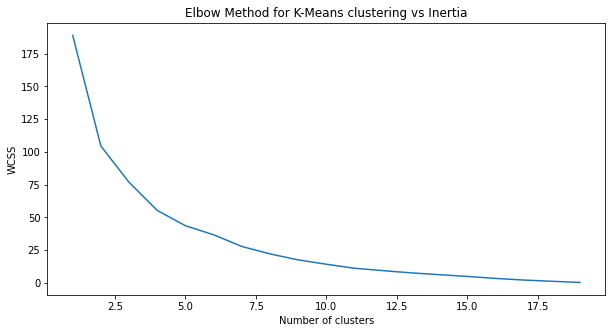

In [46]:
# Importing the library for KMeans 
from sklearn.cluster import KMeans

# Creating an empty list 
wcss = []

#ELBOW METHOD
# Creating a for loop for clusters between 1 and 12. 
# We create an instance, we fit the model and calculate the inertia 
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(df_features_scaled_1b)
    wcss.append (kmeans.inertia_)
# Plotting the inertia in front of each iteration 
plt.figure(figsize=(10,5))
plt.plot(range(1, 20), wcss)

# Setting aesthetics of the plot. 
plt.title('Elbow Method for K-Means clustering vs Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

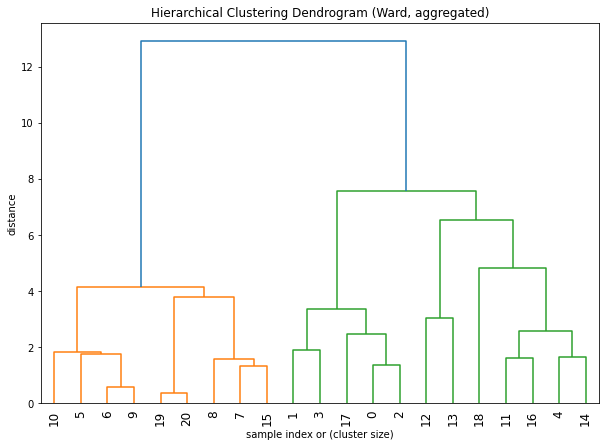

In [47]:
#DENDOGRAM METHOD

# Hierarchical algorithm for clustering. Import hierarchical algorithm method. 
from scipy.cluster.hierarchy import dendrogram, linkage

# Creating a new hierarchical algorithm  
linkage_matrix = linkage(df_features_scaled_1b, 'ward')

# Creating the figure 
figure = plt.figure(figsize=(10, 7))

# The hierarchical algorithm will be reduced, only showing the converged clusters.
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=24,                   # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,   # to get a distribution impression in truncated branches
)

# Setting aesthetics of the plot 
plt.title('Hierarchical Clustering Dendrogram (Ward, aggregated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.show()

In [48]:
#CLUSTERING
# We assume 2 clusters 
kmeans = KMeans(n_clusters=2)

# Fitting the input data
kmeans.fit(df_features_scaled_1b)

# Including the labels in the database 
df_features_1b['labels'] = kmeans.labels_

In [49]:
# Counting the number of clients under each label. 
df_features_1b['labels'].value_counts()

0    12
1     9
Name: labels, dtype: int64

In [50]:
print(f"The inertia of the model with k=3 is {kmeans.inertia_}")

The inertia of the model with k=3 is 104.43976216501181


In [51]:
df_features_1b['labels']

date
20090727    1
20090728    1
20090729    1
20090730    1
20090731    0
20090801    0
20090802    0
20090803    0
20090804    0
20090805    0
20090806    0
20090807    0
20090808    1
20090809    1
20090810    0
20090811    0
20090812    1
20090813    1
20090814    1
20090815    0
20090816    0
Name: labels, dtype: int32

In [52]:
df_features_1b[df_features_1b.index=='20090727']

,mean,median,std,mean_p1,mean_p2,mean_p3,n_cuts,inc,dec,labels
date,,,,,,,,,,
20090727,0.311625,0.146,0.535045,0.25425,0.171214,0.533429,14,10,8,1


In [53]:
df_features_1b[df_features_1b.index=='20090801']

,mean,median,std,mean_p1,mean_p2,mean_p3,n_cuts,inc,dec,labels
date,,,,,,,,,,
20090801,0.163957,0.03225,0.288952,0.023998,0.268211,0.179428,12,10,10,0


In [54]:
v_label=[]
for ind in df_bg_1b.index:
    date = df_bg_1b['date'][ind]
    if date in df_features_1b.index:
        v_label=v_label+[df_features_1b['labels'][date]]
    else:
        v_label=v_label+['NaN']
df_bg_1b['label']=v_label
df_bg_1b.head()

,power,date,time,label
0,0.072,20090727,00:00,1
1,0.171,20090727,00:30,1
2,0.093,20090727,01:00,1
3,0.055,20090727,01:30,1
4,0.055,20090727,02:00,1


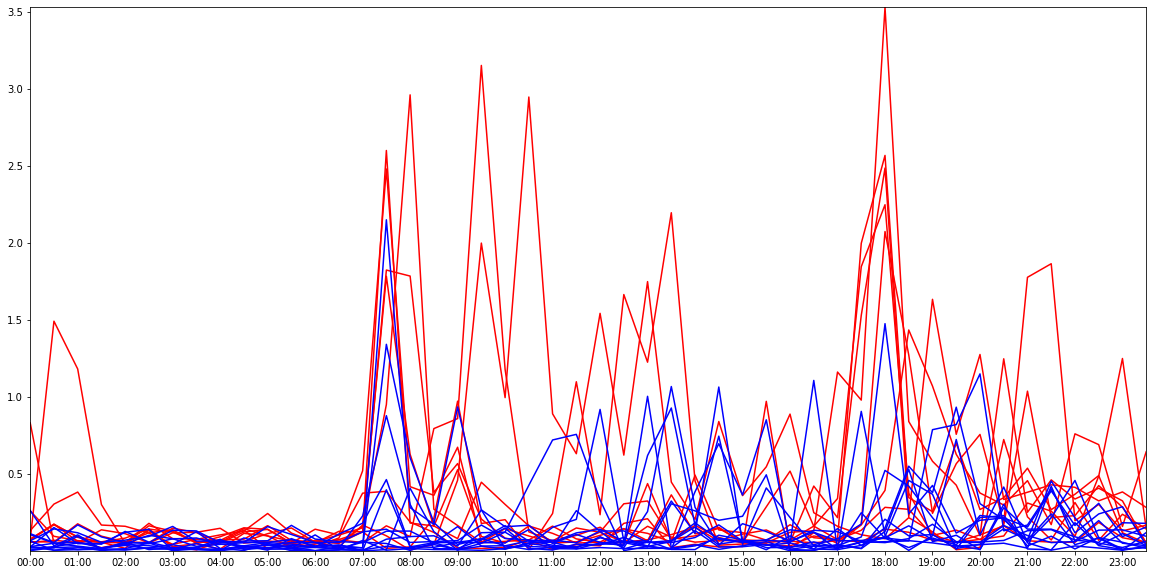

In [55]:
list_labels = df_bg_1b['label'].unique()
plt.figure(figsize=(20,10))

for label in list_labels:
    df_label = df_bg_1b.loc[df_bg_1b['label']==label]
    list_dates = df_label['date'].unique()
    for date in list_dates:
        df_label_date = df_label.loc[df_label['date']==date]
        if label==0:
            plt.plot(df_label_date['time'],df_label_date['power'],'b')
        else:
            plt.plot(df_label_date['time'],df_label_date['power'],'r')

plt.xticks(np.arange(0, 48, step=2))
plt.margins(x=0, y=0)
plt.show()        

# Approach 2
### K-Means + Hourly consumption

Distance measure: Euclidean distance. <br>
Features: Hourly consumption. <br>
Real active.

In [56]:
df_bg.head()

,power,date,time
0,0.072,20090727,00:00
1,0.171,20090727,00:30
2,0.093,20090727,01:00
3,0.055,20090727,01:30
4,0.055,20090727,02:00


In [57]:
list_hours = df_bg['time'].unique()
list_hours

array(['00:00', '00:30', '01:00', '01:30', '02:00', '02:30', '03:00',
       '03:30', '04:00', '04:30', '05:00', '05:30', '06:00', '06:30',
       '07:00', '07:30', '08:00', '08:30', '09:00', '09:30', '10:00',
       '10:30', '11:00', '11:30', '12:00', '12:30', '13:00', '13:30',
       '14:00', '14:30', '15:00', '15:30', '16:00', '16:30', '17:00',
       '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30',
       '21:00', '21:30', '22:00', '22:30', '23:00', '23:30'], dtype=object)

In [58]:
list_dates = df_bg['date'].unique()
df_a2=pd.DataFrame(columns=['time'])

for date in list_dates:
    df_bg_date = df_bg.loc[df_bg['date']==date]
    df_bg_date = df_bg_date.reset_index()
    df_a2['time'] = df_bg_date['time']
    df_a2[date] = df_bg_date['power']

df_a2=df_a2.set_index('time')
df_a2.head()

,20090727,20090728,20090729,20090730,20090731,20090801,20090802,20090803,20090804,20090805,20090806,20090807,20090808,20090809,20090810,20090811,20090812,20090813,20090814,20090815,20090816
time,,,,,,,,,,,,,,,,,,,,,
00:00,0.072,0.078,0.056,0.076,0.028679,0.021074,0.029222,0.006601,0.064951,0.021923,0.003076,0.264,0.261,0.133,0.107,0.027,0.832,0.071,0.061,0.067,0.113
00:30,0.171,0.174,0.070,0.175,0.051057,0.021055,0.005338,0.029122,0.005280,0.025958,0.022461,0.034,0.096,0.305,0.052,0.153,0.049,1.492,0.059,0.144,0.055
01:00,0.093,0.063,0.055,0.089,0.032027,0.095080,0.009320,0.052115,0.021661,0.009257,0.027659,0.105,0.068,0.383,0.057,0.048,0.061,1.182,0.177,0.119,0.170
01:30,0.055,0.060,0.138,0.058,0.015590,0.009918,0.020657,0.044943,0.014760,0.012094,0.003339,0.014,0.057,0.169,0.021,0.049,0.022,0.302,0.097,0.057,0.092
02:00,0.055,0.084,0.113,0.056,0.048022,0.006360,0.036584,0.127580,0.011413,0.056592,0.016239,0.058,0.018,0.161,0.042,0.122,0.052,0.050,0.059,0.071,0.054


In [59]:
df_a2 = df_a2.T
df_a2

time,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30
20090727,0.072000,0.171000,0.093000,0.055000,0.055000,0.180000,0.081000,0.078000,0.069000,0.146000,0.098000,0.064000,0.053000,0.128000,0.125000,2.600000,0.182000,0.163000,0.081000,0.447000,0.303000,0.164000,0.056000,0.058000,0.102000,0.146000,0.067000,0.365000,0.112000,0.154000,0.055000,0.287000,0.519000,0.161000,0.341000,1.846000,2.248000,0.375000,0.105000,0.057000,0.076000,0.170000,1.038000,0.218000,0.230000,0.425000,0.285000,0.054000
20090728,0.078000,0.174000,0.063000,0.060000,0.084000,0.143000,0.123000,0.060000,0.053000,0.124000,0.141000,0.053000,0.068000,0.054000,0.160000,0.951000,2.961000,0.272000,0.166000,0.055000,0.063000,0.072000,0.162000,0.079000,0.057000,0.054000,0.161000,0.091000,0.058000,0.068000,0.110000,0.137000,0.064000,0.054000,0.067000,0.174000,2.074000,1.273000,0.245000,0.567000,0.757000,0.181000,1.777000,1.865000,0.197000,0.303000,0.131000,0.168000
20090729,0.056000,0.070000,0.055000,0.138000,0.113000,0.053000,0.118000,0.122000,0.148000,0.052000,0.066000,0.052000,0.142000,0.105000,0.521000,2.480000,0.418000,0.362000,0.674000,0.057000,0.146000,0.098000,0.053000,0.059000,0.123000,0.307000,0.325000,0.078000,0.099000,0.148000,0.058000,0.054000,0.071000,0.162000,0.075000,1.998000,2.568000,0.347000,0.256000,0.700000,0.270000,0.346000,0.538000,0.269000,0.369000,0.490000,0.119000,0.051000
20090730,0.076000,0.175000,0.089000,0.058000,0.056000,0.119000,0.138000,0.052000,0.072000,0.077000,0.165000,0.069000,0.061000,0.050000,0.125000,1.824000,1.785000,0.381000,0.568000,0.208000,0.084000,0.049000,0.064000,0.102000,0.155000,0.052000,0.438000,0.071000,0.167000,0.088000,0.053000,0.053000,0.122000,0.132000,1.162000,0.980000,3.530000,0.841000,0.583000,0.428000,0.100000,1.248000,0.252000,0.462000,0.338000,0.408000,0.326000,0.051000
20090731,0.028679,0.051057,0.032027,0.015590,0.048022,0.102177,0.080421,0.030831,0.043748,0.054454,0.057192,0.075235,0.033946,0.038170,0.019856,2.150172,0.281986,0.173641,0.935778,0.267308,0.158101,0.167822,0.049965,0.107951,0.056766,0.034804,0.620210,0.928633,0.166619,0.745947,0.075056,0.022222,0.023879,0.059695,0.023301,0.058419,0.084870,0.067657,0.053098,0.032251,0.041565,0.051099,0.018993,0.421335,0.066741,0.197747,0.051067,0.035126
20090801,0.021074,0.021055,0.095080,0.009918,0.006360,0.021330,0.041703,0.011351,0.014264,0.023738,0.040115,0.028068,0.003009,0.008351,0.007479,0.031068,0.020912,0.042638,0.009259,0.004840,0.016140,0.037599,0.154075,0.205796,0.919422,0.064335,0.033830,0.011478,0.385461,0.696801,0.363920,0.851999,0.047893,1.107592,0.007694,0.906648,0.102426,0.004706,0.099425,0.724068,0.103524,0.415598,0.053458,0.006041,0.033433,0.020057,0.005631,0.029284
20090802,0.029222,0.005338,0.009320,0.020657,0.036584,0.014871,0.011773,0.010143,0.002618,0.018602,0.021567,0.016529,0.023849,0.012763,0.058439,0.049256,0.004638,0.051731,0.158856,0.032573,0.034735,0.010043,0.023981,0.262244,0.127273,0.013167,0.059262,0.324806,0.115919,1.064693,0.045403,0.409875,0.218209,0.034466,0.037148,0.017791,0.206798,0.098780,0.107169,0.016734,0.044360,0.144598,0.072699,0.241369,0.042065,0.084047,0.004330,0.120315
20090803,0.006601,0.029122,0.052115,0.044943,0.127580,0.057687,0.022825,0.011230,0.005490,0.085207,0.040552,0.002406,0.001995,0.006570,0.068871,0.005870,0.016456,0.010332,0.009014,0.050175,0.123147,0.427394,0.721155,0.757595,0.332185,0.003156,0.029860,0.063074,0.156802,0.039211,0.177909,0.126684,0.063775,0.122487,0.009342,0.248720,0.083042,0.022967,0.084962,0.040449,0.231081,0.215159,0.033456,0.096475,0.013958,0.089055,0.012645,0.024624
20090804,0.064951,0.005280,0.021661,0.014760,0.011413,0.019836,0.043278,0.125518,0.016870,0.003871,0.050135,0.018731,0.105110,0.010122,0.001851,0.009404,0.407634,0.126109,0.006252

In [60]:
df_features_2 = df_a2.copy()

# Importing StandardScaler method for SkLearn 
from sklearn.preprocessing import StandardScaler

# Creating the instance for Standard Scaler 
scaler = StandardScaler()

# Fitting the scaler with meter_stat
scaler.fit(df_features_2)

# Transforming the meter_stat df into an scaled one. 
df_features_scaled_2 = pd.DataFrame(scaler.transform(df_features_2), index=df_features_2.index, columns=df_features_2.columns)

In [61]:
df_features_scaled_2.head()

time,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30
20090727,-0.240424,0.061972,-0.186275,-0.109736,-0.173537,1.841737,0.215618,0.527045,0.486896,1.674463,0.319908,0.077658,0.149462,2.068082,0.016850,2.109180,-0.305525,0.003623,-0.575097,0.123759,0.370741,-0.108060,-0.366808,-0.461245,-0.317071,-0.101029,-0.545821,0.124652,-0.468322,-0.249228,-0.507762,0.269832,1.928005,0.042114,0.851687,2.304025,1.354650,0.008127,-0.590148,-0.748456,-0.527822,-0.447181,1.845393,-0.226494,0.139357,1.081675,0.368404,-0.448819
20090728,-0.206059,0.071691,-0.307995,-0.036486,0.566593,1.133418,1.025391,0.079059,0.049386,1.198472,1.024637,-0.179036,0.602794,0.030830,0.294004,0.217732,3.705214,0.624002,-0.320413,-0.399224,-0.426910,-0.257921,0.103760,-0.386133,-0.445243,-0.358306,-0.339131,-0.410679,-0.878723,-0.531299,0.065250,-0.276163,-0.318358,-0.415760,-0.276875,-0.393236,1.191555,2.379545,-0.230106,0.824170,1.410242,-0.404514,3.666500,4.116486,-0.044018,0.420545,-0.220573,0.387737
20090729,-0.332063,-0.265220,-0.340454,1.106204,1.306723,-0.589522,0.928989,1.622120,2.647099,-0.359318,-0.204542,-0.202372,2.839232,1.434882,3.152650,1.971536,0.035078,1.136241,1.201699,-0.396556,-0.151056,-0.215569,-0.380126,-0.457668,-0.257257,0.349206,0.021477,-0.436078,-0.567122,-0.268908,-0.476507,-0.578280,-0.283799,0.046393,-0.243924,2.549230,1.654595,-0.065815,-0.201817,1.234286,0.024285,0.235494,0.613250,-0.092012,0.911758,1.433917,-0.266467,-0.470834
20090730,-0.217514,0.074930,-0.202504,-0.065786,-0.148015,0.673967,1.314595,-0.120045,0.568929,0.181581,1.417974,0.194337,0.391239,-0.079292,0.016850,1.219087,2.007974,1.244381,0.884093,-0.195100,-0.357116,-0.295386,-0.331294,-0.303868,-0.166113,-0.363899,0.269945,-0.449754,-0.050321,-0.465701,-0.528599,-0.581920,-0.032009,-0.081983,4.233253,0.906999,2.556304,1.238729,0.639139,0.395553,-0.459520,3.734203,-0.091536,0.416910,0.739496,0.989550,0.525210,-0.470834
20090731,-0.488540,-0.326587,-0.433662,-0.687088,-0.351618,0.351914,0.204460,-0.646909,-0.203609,-0.306218,-0.348903,0.339847,-0.426404,-0.404984,-0.815750,1.593214,-0.161222,0.064185,1.986059,-0.115975,-0.110839,-0.101834,-0.393600,-0.282583,-0.445909,-0.411988,0.670593,1.225857,-0.053218,1.692296,-0.298810,-0.693952,-0.516440,-0.391390,-0.456864,-0.579690,-0.672911,-0.803496,-0.723626,-0.824772,-0.625821,-0.908379,-0.665731,0.309682,-0.767844,-0.149833,-0.526277,-0.587323


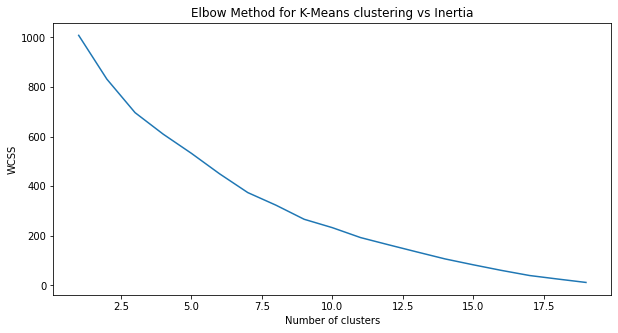

In [62]:
# Importing the library for KMeans 
from sklearn.cluster import KMeans

# Creating an empty list 
wcss = []

#ELBOW METHOD
# Creating a for loop for clusters between 1 and 12. 
# We create an instance, we fit the model and calculate the inertia 
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(df_features_scaled_2)
    wcss.append (kmeans.inertia_)
# Plotting the inertia in front of each iteration 
plt.figure(figsize=(10,5))
plt.plot(range(1, 20), wcss)

# Setting aesthetics of the plot. 
plt.title('Elbow Method for K-Means clustering vs Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

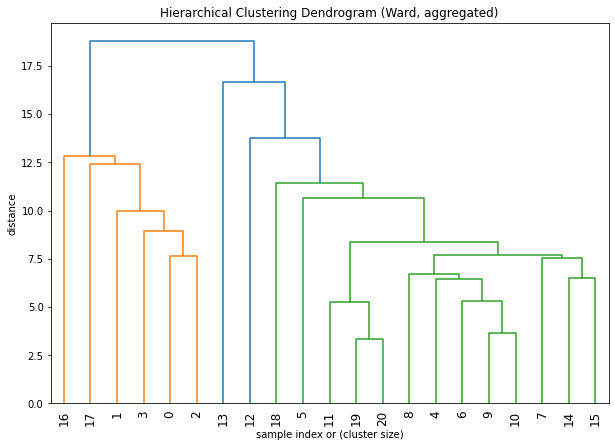

In [63]:
#DENDOGRAM METHOD

# Hierarchical algorithm for clustering. Import hierarchical algorithm method. 
from scipy.cluster.hierarchy import dendrogram, linkage

# Creating a new hierarchical algorithm  
linkage_matrix = linkage(df_features_scaled_2, 'ward')

# Creating the figure 
figure = plt.figure(figsize=(10, 7))

# The hierarchical algorithm will be reduced, only showing the converged clusters.
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=24,                   # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,   # to get a distribution impression in truncated branches
)

# Setting aesthetics of the plot 
plt.title('Hierarchical Clustering Dendrogram (Ward, aggregated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.show()

In [64]:
#CLUSTERING
# We assume 2 clusters 
kmeans = KMeans(n_clusters=2)

# Fitting the input data
kmeans.fit(df_features_scaled_2)

# Including the labels in the database 
df_features_2['labels'] = kmeans.labels_

In [65]:
# Counting the number of clients under each label. 
df_features_2['labels'].value_counts()

0    15
1     6
Name: labels, dtype: int64

In [66]:
df_features_2['labels']

20090727    1
20090728    1
20090729    1
20090730    1
20090731    0
20090801    0
20090802    0
20090803    0
20090804    0
20090805    0
20090806    0
20090807    0
20090808    0
20090809    0
20090810    0
20090811    0
20090812    1
20090813    1
20090814    0
20090815    0
20090816    0
Name: labels, dtype: int32

In [67]:
print(f"The inertia of the model with k=2 is {kmeans.inertia_}")

The inertia of the model with k=2 is 831.4884716161779


In [68]:
df_features_2[df_features_2.index=='20090727']

time,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,labels
20090727,0.072,0.171,0.093,0.055,0.055,0.18,0.081,0.078,0.069,0.146,0.098,0.064,0.053,0.128,0.125,2.6,0.182,0.163,0.081,0.447,0.303,0.164,0.056,0.058,0.102,0.146,0.067,0.365,0.112,0.154,0.055,0.287,0.519,0.161,0.341,1.846,2.248,0.375,0.105,0.057,0.076,0.17,1.038,0.218,0.23,0.425,0.285,0.054,1


In [69]:
df_features_2[df_features_2.index=='20090108']

time,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,labels


In [70]:
v_label=[]
daily_meter_2 = daily_meter.copy()
for ind in daily_meter_2.index:
    date = daily_meter_2['date'][ind]
    if date in df_features_2.index:
        v_label=v_label+[df_features_2['labels'][date]]
    else:
        v_label=v_label+['NaN']
daily_meter_2['label']=v_label
daily_meter_2.head()

,time,date,power,norm_power,label
index,,,,,
0,00:00,20090727,0.072,0.027692,1
1,00:30,20090727,0.171,0.065769,1
2,01:00,20090727,0.093,0.035769,1
3,01:30,20090727,0.055,0.021154,1
4,02:00,20090727,0.055,0.021154,1


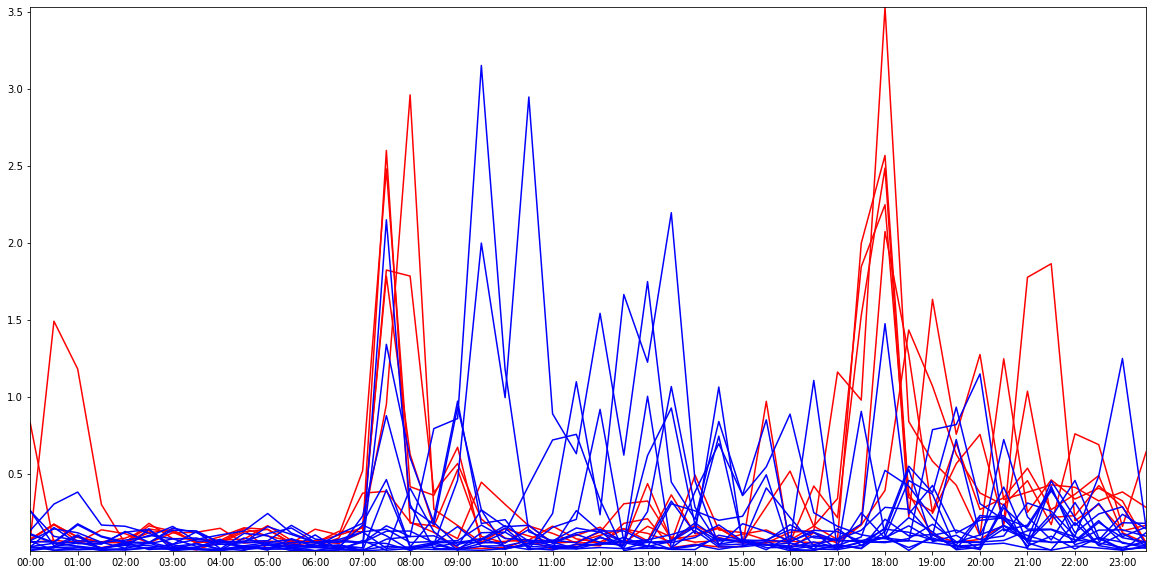

In [71]:
list_labels = daily_meter_2['label'].unique()
plt.figure(figsize=(20,10))

for label in list_labels:
    df_label = daily_meter_2.loc[daily_meter_2['label']==label]
    list_dates = df_label['date'].unique()
    for date in list_dates:
        df_label_date = df_label.loc[df_label['date']==date]
        if label==0:
            plt.plot(df_label_date['time'],df_label_date['power'],'b')
        else:
            plt.plot(df_label_date['time'],df_label_date['power'],'r')
            
plt.xticks(np.arange(0, 48, step=2))
plt.margins(x=0, y=0)
plt.show()        

# 3. K-Means
Distance measure: Dynamic Time Warping (DTW). <br>
Features: Hourly consumption. <br>
Normalized Active.

In [72]:
from tslearn.metrics import dtw
from tslearn.clustering import TimeSeriesKMeans

In [73]:
cluster_h_dtw = df_cluster
df_features_3 = df_features_2
df_features_scaled_3 = df_features_scaled_2

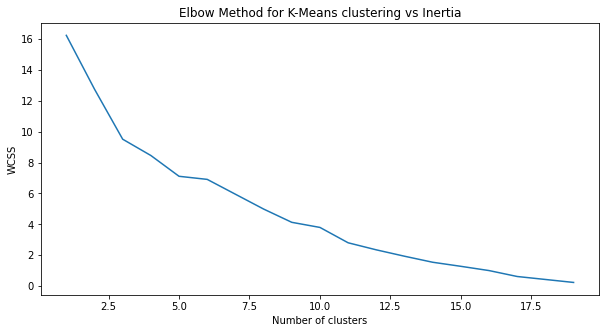

In [74]:
# Creating an empty list 
wcss = []

#ELBOW METHOD
# Creating a for loop for clusters between 1 and 12. 
# We create an instance, we fit the model and calculate the inertia 
for i in range(1, 20):
    kmeans_dtw = TimeSeriesKMeans(n_clusters = i, metric='dtw', max_iter = 10)
    kmeans_dtw.fit(df_features_scaled_3)
    wcss.append (kmeans_dtw.inertia_)
# Plotting the inertia in front of each iteration 
plt.figure(figsize=(10,5))
plt.plot(range(1, 20), wcss)

# Setting aesthetics of the plot. 
plt.title('Elbow Method for K-Means clustering vs Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

In [75]:
#CLUSTERING
# We assume 3 clusters 
kmeans_dtw = TimeSeriesKMeans(n_clusters = 2, metric='dtw', max_iter = 10)

# Fitting the input data
kmeans_dtw.fit(df_features_scaled_3)

# Including the labels in the database 
df_features_3['labels'] = kmeans_dtw.labels_

In [76]:
# Counting the number of clients under each label. 
df_features_3['labels'].value_counts()

0    17
1     4
Name: labels, dtype: int64

In [77]:
print(f"The inertia of the model with k=2 is {kmeans_dtw.inertia_}")

The inertia of the model with k=2 is 12.498133508630143


In [78]:
df_features_3[df_features_3.index=='20090727']

time,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,labels
20090727,0.072,0.171,0.093,0.055,0.055,0.18,0.081,0.078,0.069,0.146,0.098,0.064,0.053,0.128,0.125,2.6,0.182,0.163,0.081,0.447,0.303,0.164,0.056,0.058,0.102,0.146,0.067,0.365,0.112,0.154,0.055,0.287,0.519,0.161,0.341,1.846,2.248,0.375,0.105,0.057,0.076,0.17,1.038,0.218,0.23,0.425,0.285,0.054,0


In [79]:
df_features_3[df_features_3.index=='20090108']

time,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,labels


In [80]:
v_label=[]
daily_meter_3 = daily_meter.copy()
for ind in daily_meter_3.index:
    date = daily_meter_3['date'][ind]
    if date in df_features_3.index:
        v_label=v_label+[df_features_3['labels'][date]]
    else:
        v_label=v_label+['NaN']
daily_meter_3['label']=v_label
daily_meter_3.head()

,time,date,power,norm_power,label
index,,,,,
0,00:00,20090727,0.072,0.027692,0
1,00:30,20090727,0.171,0.065769,0
2,01:00,20090727,0.093,0.035769,0
3,01:30,20090727,0.055,0.021154,0
4,02:00,20090727,0.055,0.021154,0


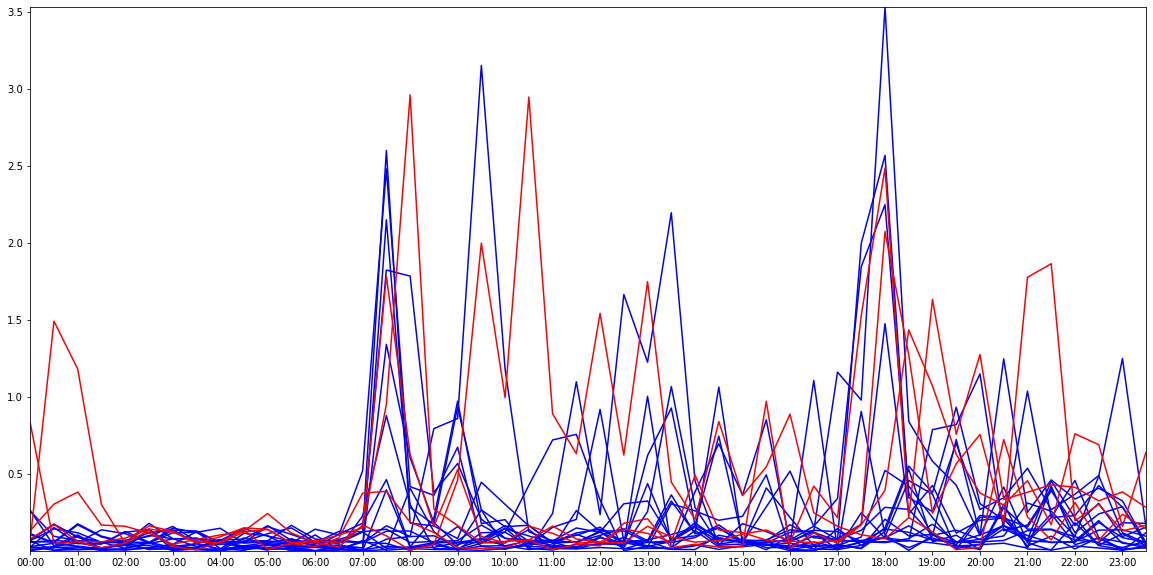

In [81]:
list_labels = daily_meter_3['label'].unique()
plt.figure(figsize=(20,10))

for label in list_labels:
    df_label = daily_meter_3.loc[daily_meter_3['label']==label]
    list_dates = df_label['date'].unique()
    for date in list_dates:
        df_label_date = df_label.loc[df_label['date']==date]
        if label==0:
            plt.plot(df_label_date['time'],df_label_date['power'],'b')
        else:
            plt.plot(df_label_date['time'],df_label_date['power'],'r')
            
plt.xticks(np.arange(0, 48, step=2))
plt.margins(x=0, y=0)
plt.show()        